In [137]:
import tensorflow_decision_forests as tfdf

import tensorflow as tf

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import math

import dtreeviz

from matplotlib import pyplot as plt
from IPython import display

# avoid "Arial font not found warnings"
import logging

logging.getLogger("matplotlib.font_manager").setLevel(level=logging.CRITICAL)

display.set_matplotlib_formats("retina")  # generate hires plots

np.random.seed(1234)  # reproducible plots/data for explanatory reasons

/tmp/tmp.PKAD8LE40W/ipykernel_3169990/31193553.py:20: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


In [138]:
def split_dataset(dataset, test_ratio=0.30, seed=1234):
    """
    Splits a panda dataframe in two, usually for train/test sets.
    Using the same random seed ensures we get the same split so
    that the description in this tutorial line up with generated images.
    """
    np.random.seed(seed)
    test_indices = np.random.rand(len(dataset)) < test_ratio
    return dataset[~test_indices], dataset[test_indices]

In [139]:
df = pd.read_parquet(
    "/home/aevans/nwp_bias/src/machine_learning/data/lstm_eval_csvs/20240725/SPRA/07_25_2024_18:32:07_full_SPRA.parquet"
)
df.head()
print(sorted(df["target_error"].unique()))

[-30.0, -28.0, -25.0, -24.0, -22.0, -19.0, -14.0, -13.0, -12.0, -11.0, -10.0, -9.0, -8.0, -7.0, -6.0, -5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 41.0, 43.0, 44.0, 62.0, 79.0]


In [140]:
df["target_error"] = df["target_error"].shift(6).fillna(-999)
t = df["valid_time"].tolist()
df = df.drop(columns="valid_time")
df = df.fillna(-999)
df.head()
# df['target_error'] = df['target_error']+30

,valid_time_cos,valid_time_sin,target_error,t2m_SPRA,sh2_SPRA,d2m_SPRA,r2_SPRA,u10_SPRA,v10_SPRA,tp_SPRA,...,relh_COBL,srad_COBL,pres_COBL,mslp_COBL,wspd_sonic_mean_COBL,wspd_sonic_COBL,wmax_sonic_COBL,wdir_sonic_COBL,snow_depth_COBL,precip_total_COBL
0,0.999853,0.017166,-999.0,-22.144995,0.00040,-27.480002,60.500000,4.680628,0.288429,0.0,...,68.749298,0.0,985.457886,990.958740,1.387094,1.816909,2.575043,228.848602,0.035221,0.0
1,0.999853,0.017166,-999.0,-22.384985,0.00042,-26.949683,64.900002,4.413494,0.568998,0.0,...,71.334389,0.0,985.741882,991.358643,1.166361,1.045074,1.739692,252.451096,0.035572,0.0
2,0.999853,0.017166,-999.0,-22.421271,0.00041,-27.318533,63.000000,4.146494,0.479216,0.0,...,70.633202,0.0,985.844788,991.460388,1.277524,1.172637,1.845446,242.436707,0.039352,0.0
3,0.999853,0.017166,-999.0,-22.729544,0.00040,-27.650275,62.799999,4.204945,0.494606,0.0,...,73.214256,0.0,985.453979,991.115173,2.061122,1.739522,3.045453,217.181000,0.037502,0.0
4,0.999853,0.017166,-999.0,-23.103598,0.00041,-27.331671,66.599998,4.116848,0.412491,0.0,...,71.101593,0.0,985.503174,991.092712,1.935415,2.538242,3.777528,243.162003,0.037962,0.0


In [141]:
penguin_label = "target_error"  # Name of the classification target label
classes = list(df[penguin_label].unique())
df[penguin_label] = df[penguin_label].map(classes.index)

In [142]:
# classes

In [143]:
features = [c for c in df.columns if c != "target_error"]
print(features)

['valid_time_cos', 'valid_time_sin', 't2m_SPRA', 'sh2_SPRA', 'd2m_SPRA', 'r2_SPRA', 'u10_SPRA', 'v10_SPRA', 'tp_SPRA', 'mslma_SPRA', 'tcc_SPRA', 'asnow_SPRA', 'cape_SPRA', 'dswrf_SPRA', 'dlwrf_SPRA', 'gh_SPRA', 'u_total_SPRA', 'u_dir_SPRA', 'new_tp_SPRA', 'lulc_cat_SPRA', 'elev_cat_SPRA', 'slope_cat_SPRA', 't2m_JOHN', 'sh2_JOHN', 'd2m_JOHN', 'r2_JOHN', 'u10_JOHN', 'v10_JOHN', 'tp_JOHN', 'mslma_JOHN', 'tcc_JOHN', 'asnow_JOHN', 'cape_JOHN', 'dswrf_JOHN', 'dlwrf_JOHN', 'gh_JOHN', 'u_total_JOHN', 'u_dir_JOHN', 'new_tp_JOHN', 'lulc_cat_JOHN', 'elev_cat_JOHN', 'slope_cat_JOHN', 't2m_COBL', 'sh2_COBL', 'd2m_COBL', 'r2_COBL', 'u10_COBL', 'v10_COBL', 'tp_COBL', 'mslma_COBL', 'tcc_COBL', 'asnow_COBL', 'cape_COBL', 'dswrf_COBL', 'dlwrf_COBL', 'gh_COBL', 'u_total_COBL', 'u_dir_COBL', 'new_tp_COBL', 'lulc_cat_COBL', 'elev_cat_COBL', 'slope_cat_COBL', 'lat_SPRA', 'lon_SPRA', 'elev_SPRA', 'tair_SPRA', 'ta9m_SPRA', 'td_SPRA', 'relh_SPRA', 'srad_SPRA', 'pres_SPRA', 'mslp_SPRA', 'wspd_sonic_mean_SPRA', 

In [144]:
# Split into training and test sets
train_ds_pd, test_ds_pd = split_dataset(df)
print(
    f"{len(train_ds_pd)} examples in training, {len(test_ds_pd)} examples for testing."
)

34245 examples in training, 14740 examples for testing.


In [156]:
# Debugging: Check if the data in TensorFlow datasets are correct
for x, y in train_ds.take(1):
    print("Sample features:", x)
    print("Sample label:", y.numpy())

Sample features: {'valid_time_cos': <tf.Tensor: shape=(1000,), dtype=float64, numpy=
array([0.99985265, 0.99985265, 0.99985265, 0.99985265, 0.99985265,
       0.99985265, 0.99985265, 0.99985265, 0.99985265, 0.99985265,
       0.99985265, 0.99985265, 0.99985265, 0.99985265, 0.99941063,
       0.99941063, 0.99941063, 0.99941063, 0.99941063, 0.99941063,
       0.99941063, 0.99941063, 0.99941063, 0.99941063, 0.99941063,
       0.99941063, 0.99941063, 0.99941063, 0.99941063, 0.99941063,
       0.99941063, 0.99867409, 0.99867409, 0.99764323, 0.99764323,
       0.99764323, 0.99764323, 0.99764323, 0.99764323, 0.99764323,
       0.99764323, 0.99764323, 0.99764323, 0.99764323, 0.99764323,
       0.99631836, 0.99631836, 0.99631836, 0.99631836, 0.99631836,
       0.99631836, 0.99631836, 0.99631836, 0.99631836, 0.99631836,
       0.99469988, 0.99469988, 0.99469988, 0.99469988, 0.99469988,
       0.99469988, 0.99469988, 0.99469988, 0.99469988, 0.99469988,
       0.99469988, 0.99469988, 0.99469988, 0

2024-07-26 18:25:03.499973: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [145]:
# # Convert to tensorflow data sets
# train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=penguin_label)
# test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd, label=penguin_label)

In [146]:
# Convert to tensorflow data sets with specified task
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    train_ds_pd, label=penguin_label, task=tfdf.keras.Task.REGRESSION
)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    test_ds_pd, label=penguin_label, task=tfdf.keras.Task.REGRESSION
)

In [147]:
# Train a Random Forest model for regression
rmodel = tfdf.keras.RandomForestModel(
    task=tfdf.keras.Task.REGRESSION, verbose=0, random_seed=1234
)
rmodel.fit(train_ds)

[INFO 24-07-26 18:18:55.1665 UTC kernel.cc:1233] Loading model from path /tmp/tmp.PKAD8LE40W/tmpeinvqkpe/model/ with prefix 167c93c4d5ed487c
[INFO 24-07-26 18:18:55.8391 UTC decision_forest.cc:734] Model loaded with 300 root(s), 476410 node(s), and 92 input feature(s).
[INFO 24-07-26 18:18:55.8392 UTC abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-07-26 18:18:55.8392 UTC kernel.cc:1061] Use fast generic engine


In [148]:
# Compile the model with appropriate metrics for regression
rmodel.compile(metrics=["mean_squared_error"])

In [149]:
# # Train a Random Forest model
# cmodel = tfdf.keras.RandomForestModel(verbose=0, random_seed=1234)
# y_train = cmodel.fit(train_ds)

In [150]:
# cmodel.compile(metrics=["accuracy"])
y_test = rmodel.evaluate(test_ds, return_dict=True, verbose=0)
print(y_test)

{'loss': 0.0, 'mean_squared_error': 8.906542778015137}


In [151]:
# Function to get predictions
def get_predictions(dataset):
    y_true = np.concatenate([y for x, y in dataset], axis=0)
    y_pred = rmodel.predict(dataset).reshape(-1)
    return y_true, y_pred

In [152]:
y_true_0, y_pred_0 = get_predictions(train_ds)
y_true_1, y_pred_1 = get_predictions(test_ds)

y_true = np.concatenate([y_true_0, y_true_1])
y_pred = np.concatenate([y_pred_0, y_pred_1])

 1/35 [..............................] - ETA: 4s

2024-07-26 18:18:59.928216: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


 1/15 [=>............................] - ETA: 2s

2024-07-26 18:19:02.469164: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


15/15 [==============================] - 1s 48ms/step


In [153]:
# from sklearn.metrics import confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Compute the confusion matrix
# cm = confusion_matrix(y_true, y_pred)

# # Plot the confusion matrix
# plt.figure(figsize=(10, 7))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')
# plt.show()

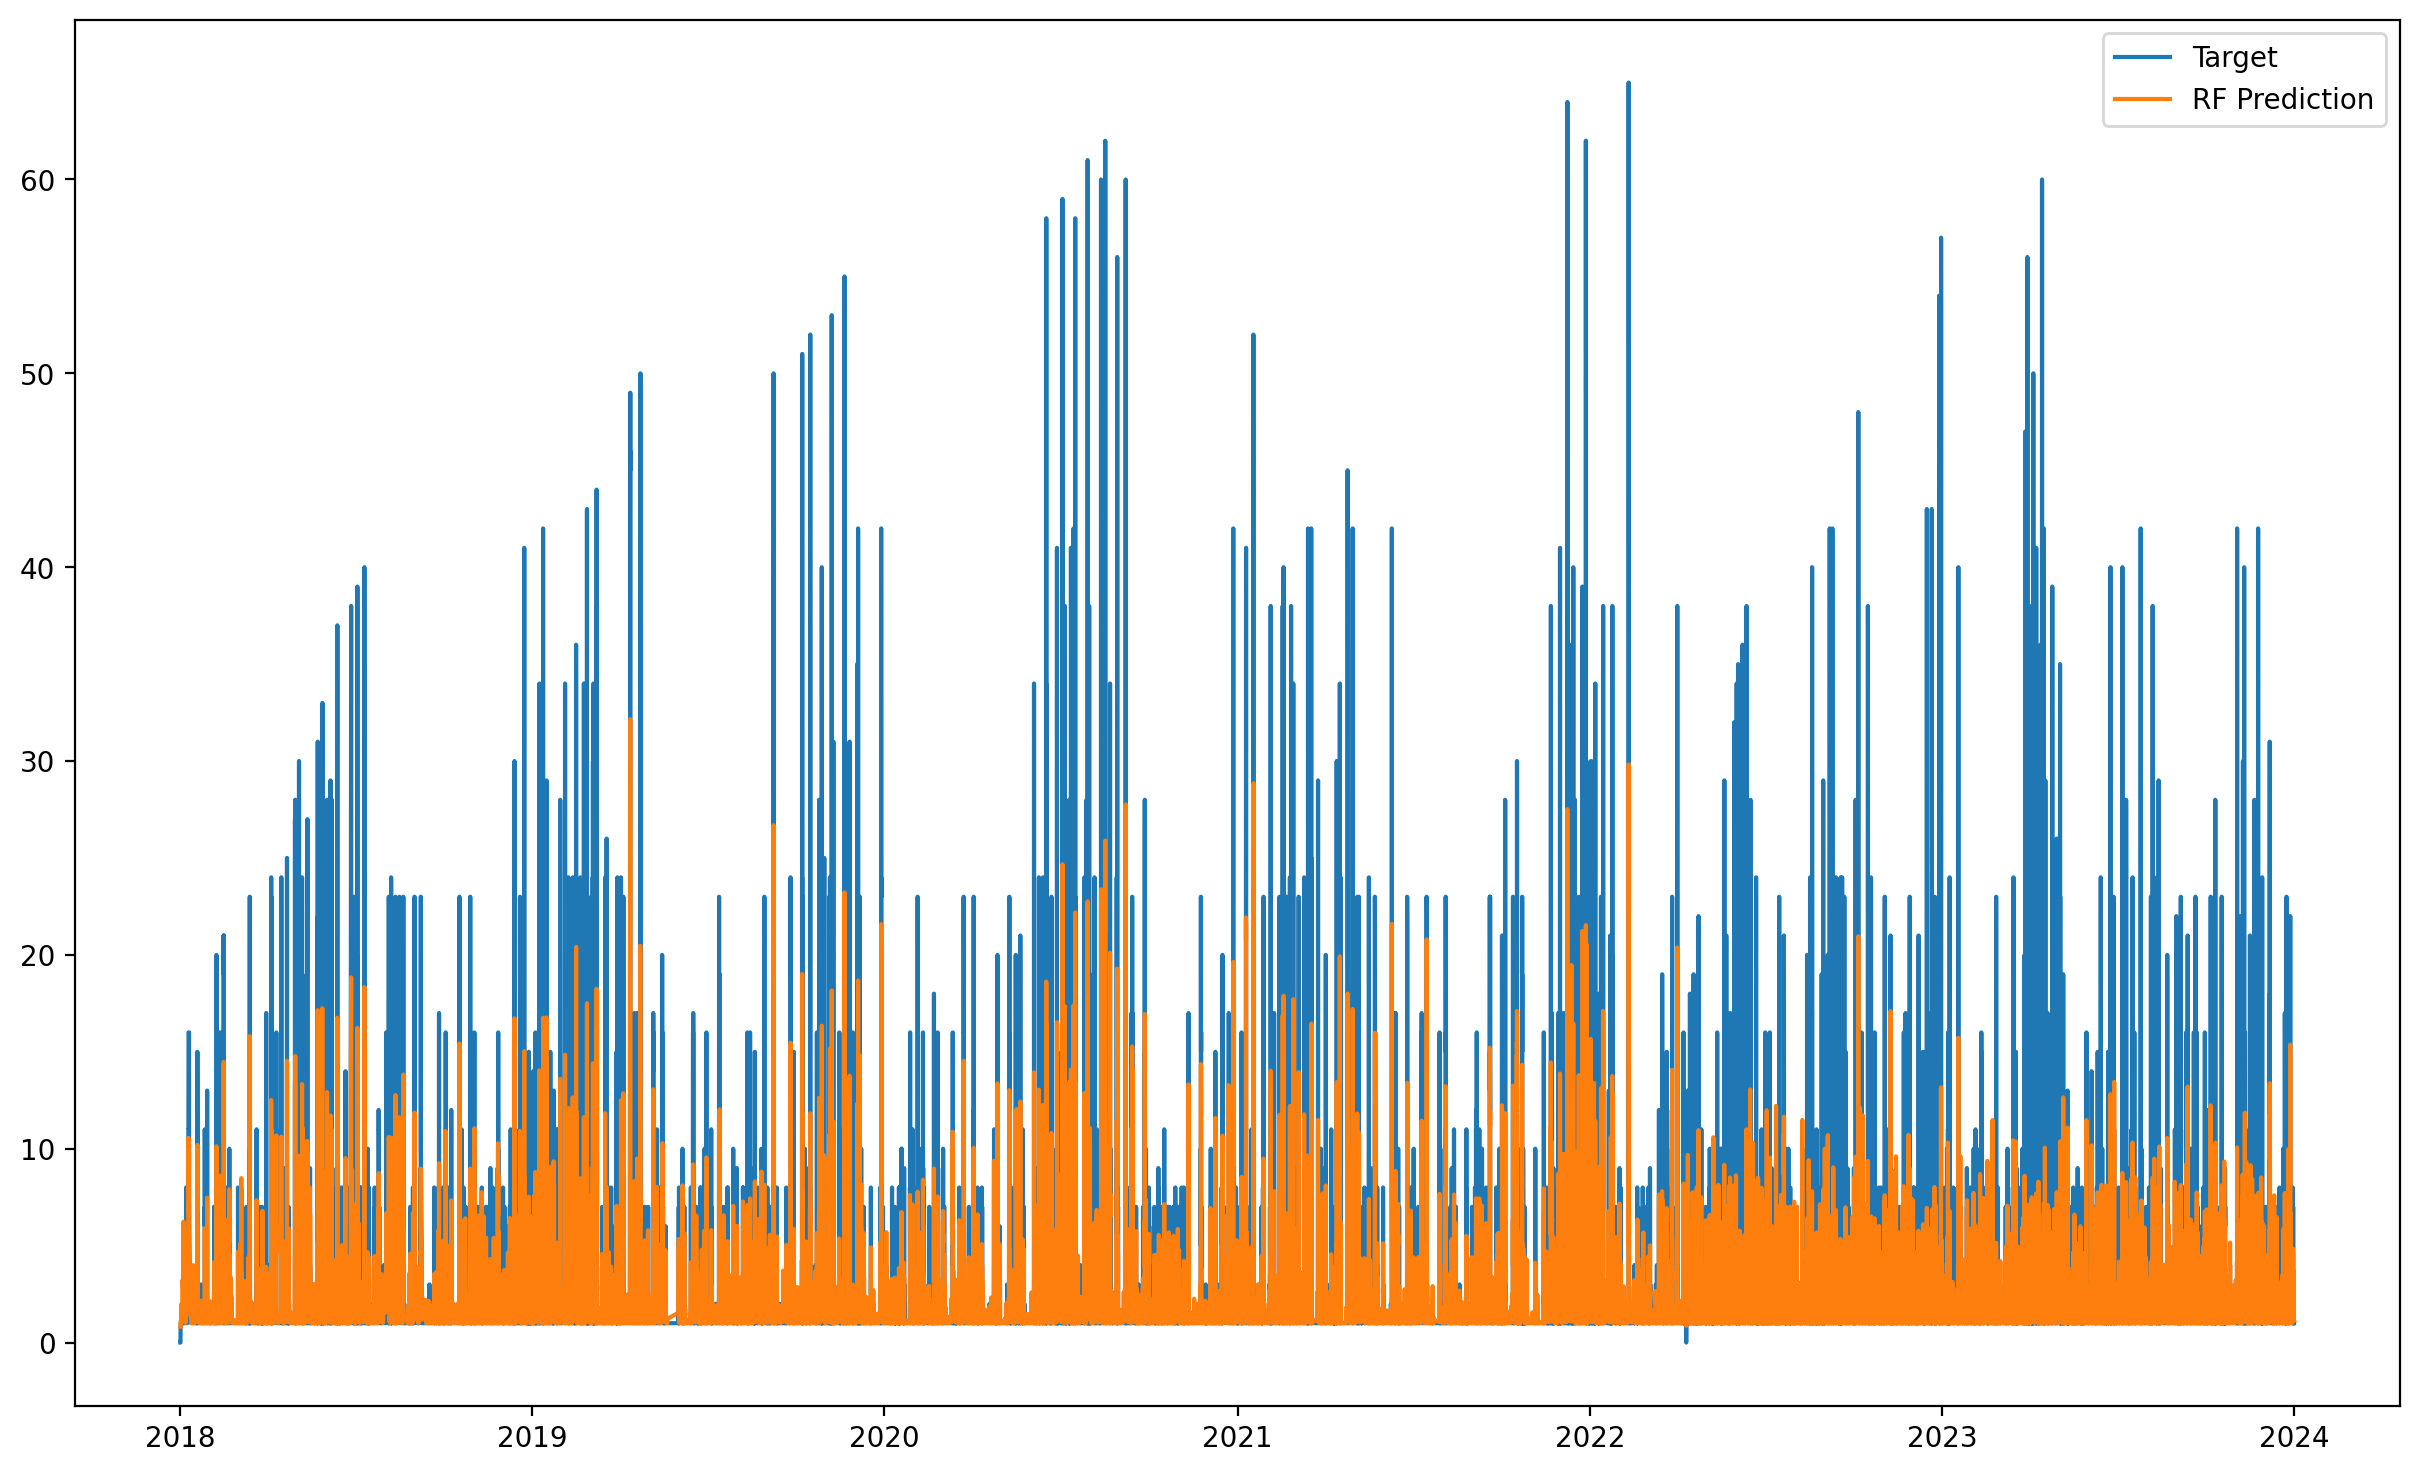

In [154]:
import matplotlib.pyplot as pl

s = 0
f = -1

plt.figure(figsize=(15, 9))
plt.plot(t[s:f], y_true[s:f], label="Target")
plt.plot(t[s:f], y_pred[s:f], label="RF Prediction")
plt.legend()
plt.show()